In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as sts
import statsmodels.api as sm
import arviz as az

In [2]:
N = 1000
alpha = 2.5
decay = -0.0075
bS = 0.5
sig = 0.075

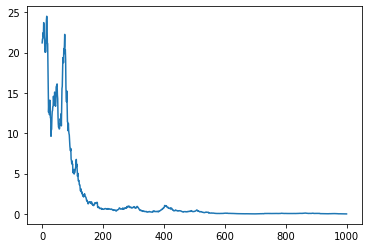

In [3]:
t = np.arange(1, N+1)
seasonality = np.where( t//(365/2) % 2 == 0, 1, 0)
ar = np.random.normal(0, sig,size=N).cumsum()
mu = ar + decay*t + bS*seasonality
y = np.exp(alpha)*np.exp(mu)
plt.plot(y)


In [4]:
df = pd.DataFrame({
    "t":t,
    "season":seasonality,
    "y":y
})

df.head(10)

,t,season,y
0,1,1,21.202533
1,2,1,21.667264
2,3,1,21.765052
3,4,1,22.447021
4,5,1,22.034935
5,6,1,23.711298
6,7,1,23.252533
7,8,1,21.942198
8,9,1,21.528322
9,10,1,20.075582


In [5]:
model = sm.Poisson.from_formula(
    "y ~ t + season + y_tminus1", 
    df.assign(y_tminus1 = df.y.shift())
).fit()
model.summary()

Optimization terminated successfully.
         Current function value: 0.743230
         Iterations 13


<class 'statsmodels.iolib.summary.Summary'>
"""
                          Poisson Regression Results                          
==============================================================================
Dep. Variable:                      y   No. Observations:                  999
Model:                        Poisson   Df Residuals:                      995
Method:                           MLE   Df Model:                            3
Date:                Sat, 09 Apr 2022   Pseudo R-squ.:                  0.7913
Time:                        17:12:18   Log-Likelihood:                -742.49
converged:                       True   LL-Null:                       -3558.3
Covariance Type:            nonrobust   LLR p-value:                     0.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.9267      0.123      7.520      0.000       0.685       1.168
t             -0.0056      0.000    -20.867      0.000      -0.006      -0.005
season         0.8389      0.106      7.943      0.000       0.632       1.046
y_tminus1      0.0718      0.004     16.753      0.000       0.063       0.080
==============================================================================
"""

In [6]:
yhat = model.predict(df.assign(y_tminus1 = df.y.shift()))
ysim = np.random.poisson(yhat[1:], size=(4000, len(t)-1))
bounds = az.hdi(ysim)

/var/folders/m_/3366cw3j3fx4gcwg7_c6f7xr0000gn/T/ipykernel_50215/1068311259.py:3: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  bounds = az.hdi(ysim)


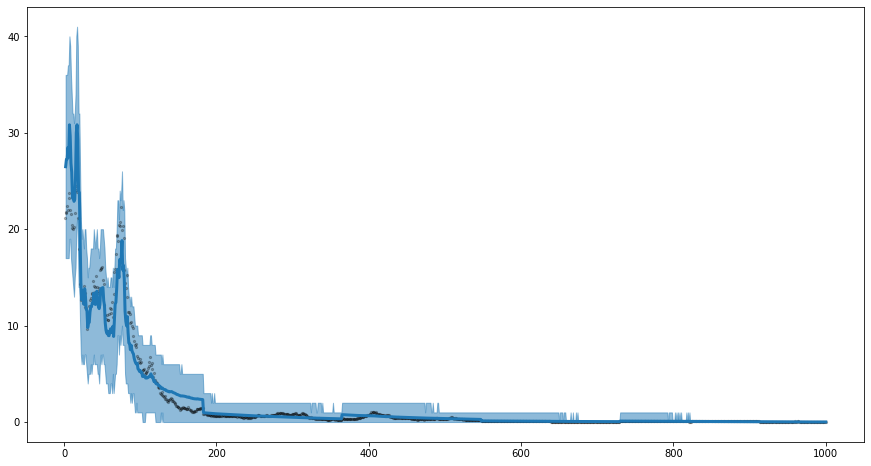

In [7]:
fig, ax = plt.subplots(1,1, figsize=(15,8))
ax.plot(t[1:],  yhat[1:], color="C0", lw=3)
ax.fill_between(t[1:],bounds[:,0], bounds[:,1], color="C0", alpha=0.5)
ax.scatter(t, y, color="k", alpha=0.25, s=5)

# Multiple products

In [13]:
np.random.seed(99)
M = 50 # products
T = 1000
mu_alpha = 2.
sig_alpha = 0.1
alpha = np.random.normal(mu_alpha, sig_alpha,size=M)

mu_decay = -0.0075
sig_decay = .001
Bdecay = np.random.normal(mu_decay, sig_decay, size=M)

mu_bS = 0.5
sig_bS = 0.015
bS = np.random.normal(mu_bS, sig_bS, size=M)

sig_mu = 0.05
sig = np.random.normal(sig_mu, 0.001, size=M)

In [14]:
true_effects = {
    "alpha":alpha,
    "decay":Bdecay,
    "bS":bS,
    "AR":sig
}

In [15]:
np.random.seed(99)

t = np.arange(1, T+1)
seasonality = np.where( t//(365/2) % 2 == 0, 1, 0)
wave = (np.sin(t/(365/6.3))+1)/2
ar = np.random.normal(0, sig,size=(T,M)).cumsum(0)
mu = alpha[:,None] + ar.T + Bdecay[:,None]*t + bS[:,None]*wave
y = np.exp(mu).T

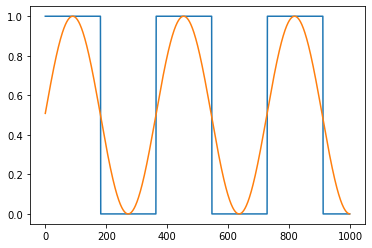

In [16]:
plt.plot(seasonality)

wave = (np.sin(t/(365/6.3))+1)/2
plt.plot( wave )

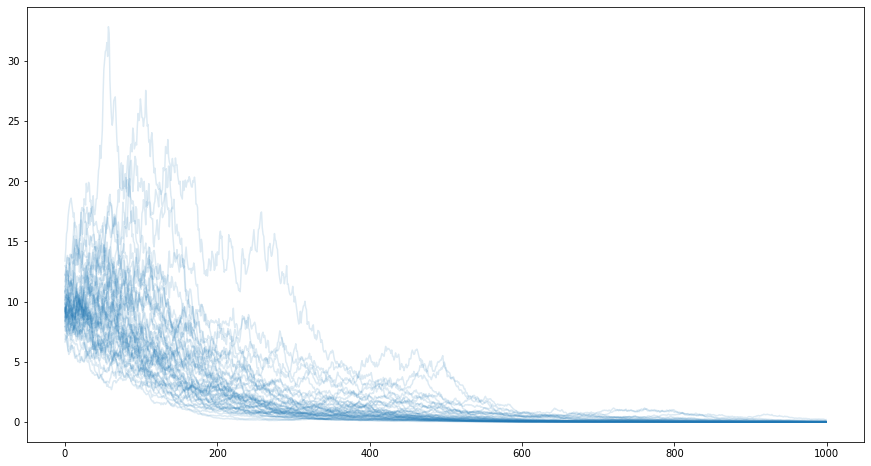

In [17]:
fig, ax = plt.subplots(1,1,figsize=(15,8))
ax.plot(y, alpha=0.15, color="C0");

 * How far ahead can people rent?

# Bayesian Model

In [18]:
import pymc3 as pm

In [20]:
df = pd.DataFrame({
    "style":np.repeat([f"P{i}" for i in range(M)], T),
    "t":np.tile(t, M),
    "season":np.tile(wave,M),
    "y":y.T.ravel()
}).assign(y_tminus1 = lambda d: d.groupby("style").y.shift(1))\
    .loc[lambda d: d.t!=1]

df

,style,t,season,y,y_tminus1
1,P0,2,0.517257,9.029326,9.182734
2,P0,3,0.525879,8.549466,9.029326
3,P0,4,0.534493,7.372550,8.549466
4,P0,5,0.543097,7.832013,7.372550
5,P0,6,0.551688,7.590695,7.832013
...,...,...,...,...,...
49995,P49,996,0.001914,0.049814,0.049682
49996,P49,997,0.001234,0.048203,0.049814
49997,P49,998,0.000702,0.045418,0.048203
49998,P49,999,0.000319,0.043948,0.045418


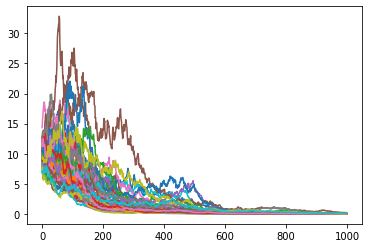

In [21]:
gpby = df.set_index(["style", "t"]).groupby("style")["y"]
gpby.plot(use_index=False);

In [25]:
s_, s_labels = pd.factorize(df["style"])

coords={"style":s_labels}
with pm.Model(coords=coords) as m:
    alpha = pm.Normal("alpha", 2, 0.5, dims="style")
    bS = pm.Normal("bS", 0.75, .2, dims="style")
    gamma = pm.Normal("gamma", -5, 1.5, dims="style")
    bAR = pm.Normal("bAR", 0.05, 0.001)
    
    mu = pm.Deterministic("mu", alpha[s_] + bS[s_]*df.season.values + gamma[s_]*df.t.values/1000 + bAR*df.y_tminus1 )
    lambd = pm.Deterministic("lambd", pm.math.exp(mu))
    rentals = pm.Poisson("rentals", lambd, observed=df.y)
    

### Prior Predictive Simulation

In [26]:
with m:
    prior_pred = pm.sample_prior_predictive()

/var/folders/m_/3366cw3j3fx4gcwg7_c6f7xr0000gn/T/ipykernel_50215/3860918794.py:5: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  bounds = az.hdi(arr)
/var/folders/m_/3366cw3j3fx4gcwg7_c6f7xr0000gn/T/ipykernel_50215/3860918794.py:11: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  bounds = az.hdi(arr)
/var/folders/m_/3366cw3j3fx4gcwg7_c6f7xr0000gn/T/ipykernel_50215/3860918794.py:17: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  bounds = az.hdi(arr)


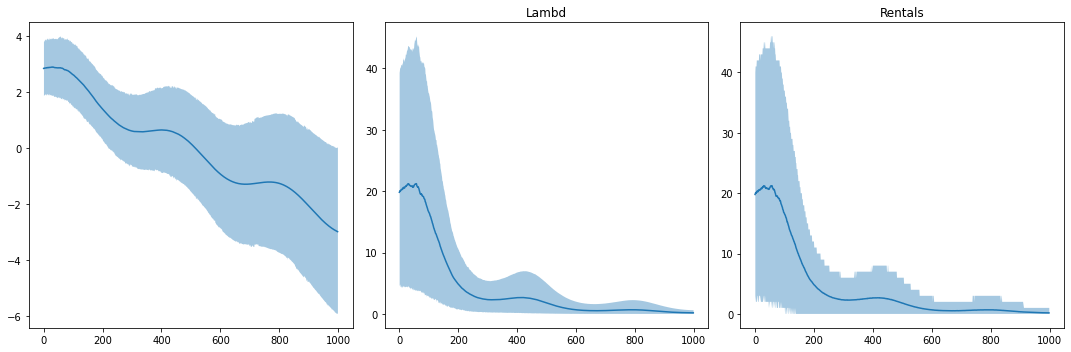

In [27]:
fig, ax = plt.subplots(1,3,figsize=(15,5))

ax[1].set_title("mu")
arr = prior_pred["mu"].reshape(500*M, 999)
bounds = az.hdi(arr)
ax[0].plot(arr.mean(0))
ax[0].fill_between(np.arange(1,T), bounds[:,0], bounds[:,1], alpha=0.4)

ax[1].set_title("Lambd")
arr = prior_pred["lambd"].reshape(500*M, 999)
bounds = az.hdi(arr)
ax[1].plot(arr.mean(0))
ax[1].fill_between(np.arange(1,T), bounds[:,0], bounds[:,1], alpha=0.4)

ax[2].set_title("Rentals")
arr = prior_pred["rentals"].reshape(500*M, 999)
bounds = az.hdi(arr)
ax[2].plot(arr.mean(0))
ax[2].fill_between(np.arange(1,T), bounds[:,0], bounds[:,1], alpha=0.4)
plt.tight_layout()

In [29]:
with m:
    trace = pm.sample(init="advi+adapt_diag", return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...


Convergence achieved at 43600
Interrupted at 43,599 [21%]: Average Loss = 5.6709e+27
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [bAR, gamma, bS, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 245 seconds.


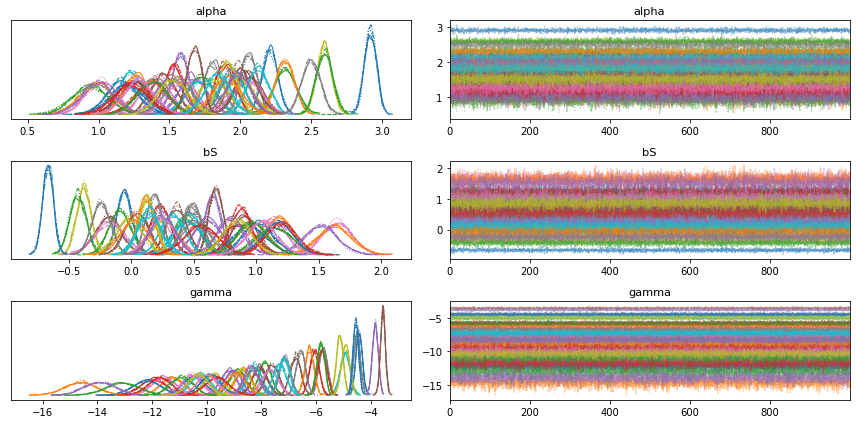

In [30]:
pm.plot_trace(trace, var_names=["alpha", "bS", "gamma"])
plt.tight_layout()

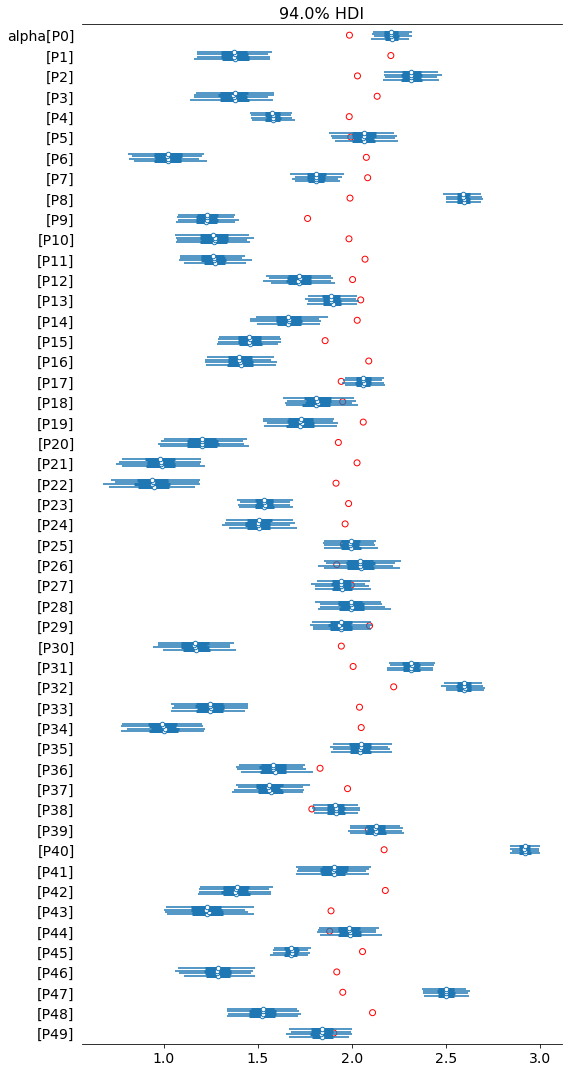

In [31]:
fig ,ax = plt.subplots(1,1,figsize=(8, 15))
pm.plot_forest( trace, var_names=["alpha"], ax=ax )
ax.scatter( true_effects["alpha"][::-1], ax.get_yticks(), 
            facecolor="none",edgecolor="r")
plt.tight_layout()

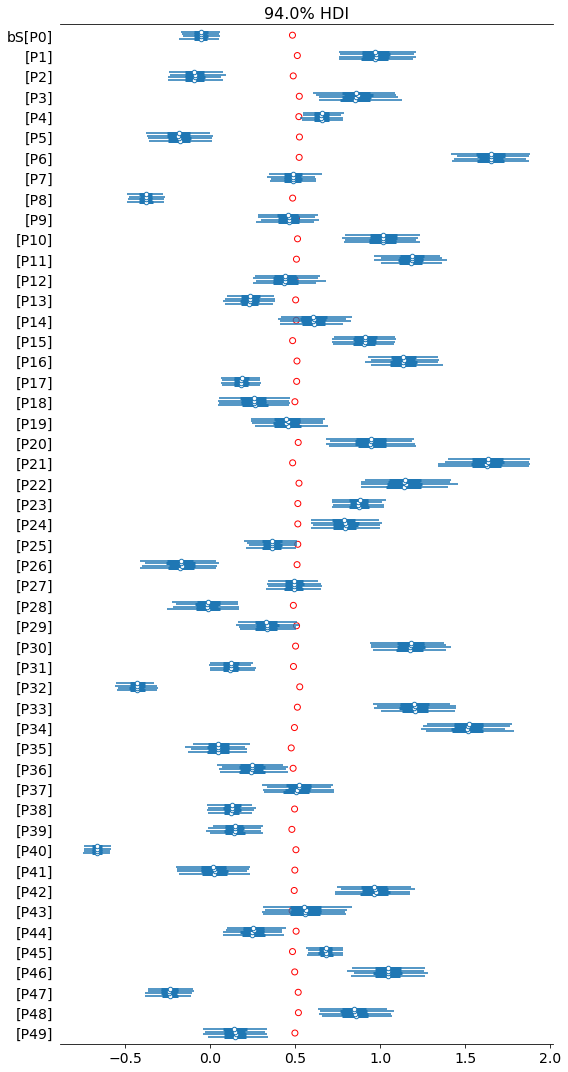

In [32]:
fig ,ax = plt.subplots(1,1,figsize=(8, 15))
pm.plot_forest( trace, var_names=["bS"], ax=ax )
ax.scatter( true_effects["bS"][::-1], ax.get_yticks(), 
            facecolor="none",edgecolor="r")
plt.tight_layout()

# Hierarchical Model

In [99]:
def hierarchical_normal(name, dims, μ=0.):
    Δ = pm.Normal('Δ_{}'.format(name), 0., 0.001, dims=dims)
    σ = pm.Exponential('σ_{}'.format(name), 0.1)
    
    return pm.Deterministic(name, μ + Δ * σ)

In [96]:
with pm.Model(coords=coords) as m2:
    mu_alpha = pm.Normal("mu_alpha", 2, 0.5)
    alpha = hierarchical_normal("alpha", dims="style", μ=mu_alpha)
    
    mu_bS = pm.Normal("mu_bS", 0.75, .2)
    bS = hierarchical_normal("bS", dims="style", μ=mu_bS)

    mu_gamma = pm.Normal("mu_gamma", -5, 1.5)
    gamma = hierarchical_normal("gamma", dims="style", μ=mu_gamma)

    bAR = pm.Normal("bAR", 0.05, 0.001)
    
    mu = pm.Deterministic("mu", alpha[s_] + bS[s_]*df.season.values + gamma[s_]*df.t.values/1000 + bAR*df.y_tminus1 )
    lambd = pm.Deterministic("lambd", pm.math.exp(mu))
    rentals = pm.Poisson("rentals", lambd, observed=df.y)
    

### Prior predictive

In [97]:
with m2:
    prior_pred = pm.sample_prior_predictive()

/var/folders/m_/3366cw3j3fx4gcwg7_c6f7xr0000gn/T/ipykernel_50215/3860918794.py:5: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  bounds = az.hdi(arr)
/var/folders/m_/3366cw3j3fx4gcwg7_c6f7xr0000gn/T/ipykernel_50215/3860918794.py:11: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  bounds = az.hdi(arr)
/var/folders/m_/3366cw3j3fx4gcwg7_c6f7xr0000gn/T/ipykernel_50215/3860918794.py:17: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  bounds = az.hdi(arr)


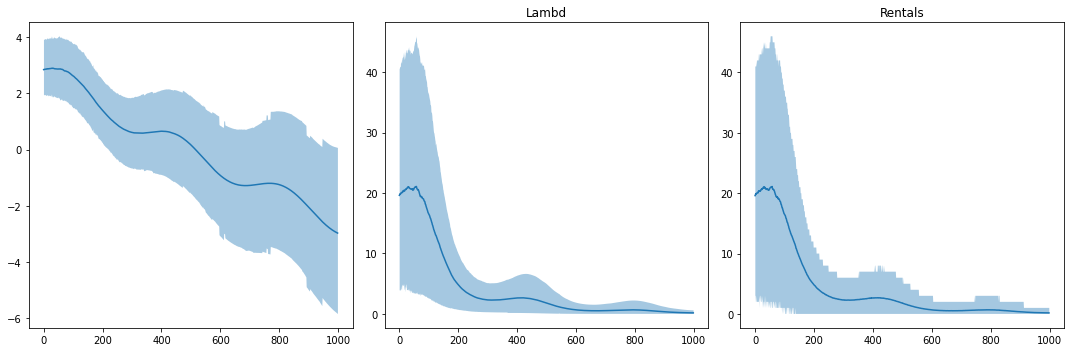

In [98]:
fig, ax = plt.subplots(1,3,figsize=(15,5))

ax[1].set_title("mu")
arr = prior_pred["mu"].reshape(500*M, 999)
bounds = az.hdi(arr)
ax[0].plot(arr.mean(0))
ax[0].fill_between(np.arange(1,T), bounds[:,0], bounds[:,1], alpha=0.4)

ax[1].set_title("Lambd")
arr = prior_pred["lambd"].reshape(500*M, 999)
bounds = az.hdi(arr)
ax[1].plot(arr.mean(0))
ax[1].fill_between(np.arange(1,T), bounds[:,0], bounds[:,1], alpha=0.4)

ax[2].set_title("Rentals")
arr = prior_pred["rentals"].reshape(500*M, 999)
bounds = az.hdi(arr)
ax[2].plot(arr.mean(0))
ax[2].fill_between(np.arange(1,T), bounds[:,0], bounds[:,1], alpha=0.4)
plt.tight_layout()

### Fit Model

In [103]:
with m2:
    trace2 = pm.sample(init="advi+adapt_diag", return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...


Convergence achieved at 75800
Interrupted at 75,799 [37%]: Average Loss = 2.3942e+57
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [bAR, σ_gamma, Δ_gamma, mu_gamma, σ_bS, Δ_bS, mu_bS, σ_alpha, Δ_alpha, mu_alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 665 seconds.
The number of effective samples is smaller than 10% for some parameters.


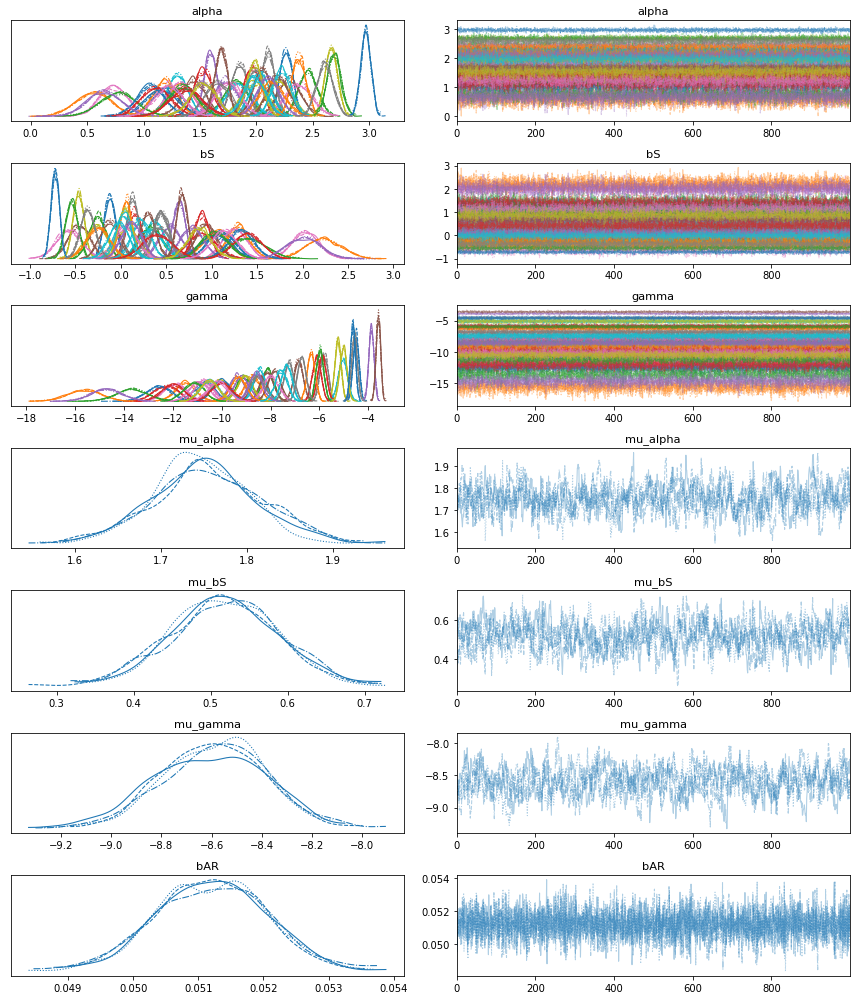

In [181]:
pm.plot_trace(trace2, var_names=["alpha", "bS", "gamma",
                                "mu_alpha", "mu_bS", "mu_gamma", "bAR"])
plt.tight_layout()

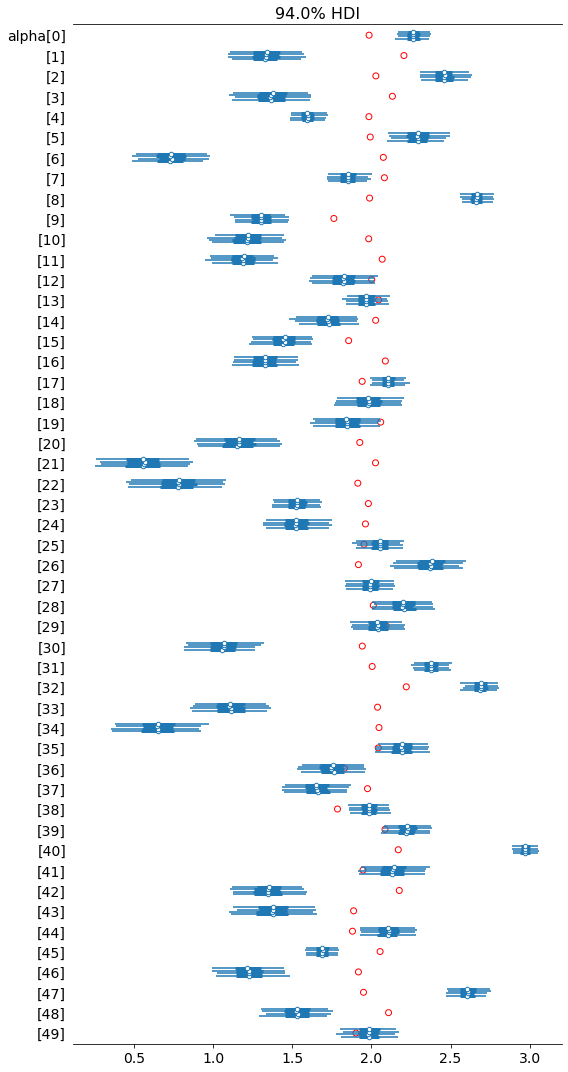

In [108]:
fig ,ax = plt.subplots(1,1,figsize=(8, 15))
pm.plot_forest( trace2, var_names=["alpha"], ax=ax )
ax.scatter( true_effects["alpha"][::-1], ax.get_yticks(), 
            facecolor="none",edgecolor="r")
plt.tight_layout()

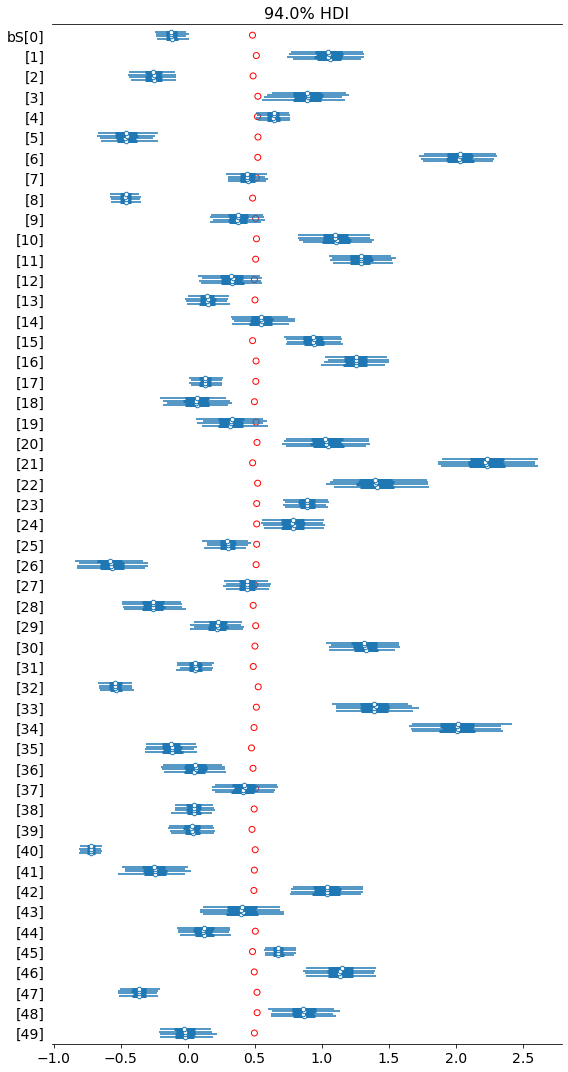

In [109]:
fig ,ax = plt.subplots(1,1,figsize=(8, 15))
pm.plot_forest( trace2, var_names=["bS"], ax=ax )
ax.scatter( true_effects["bS"][::-1], ax.get_yticks(), 
            facecolor="none",edgecolor="r")
plt.tight_layout()

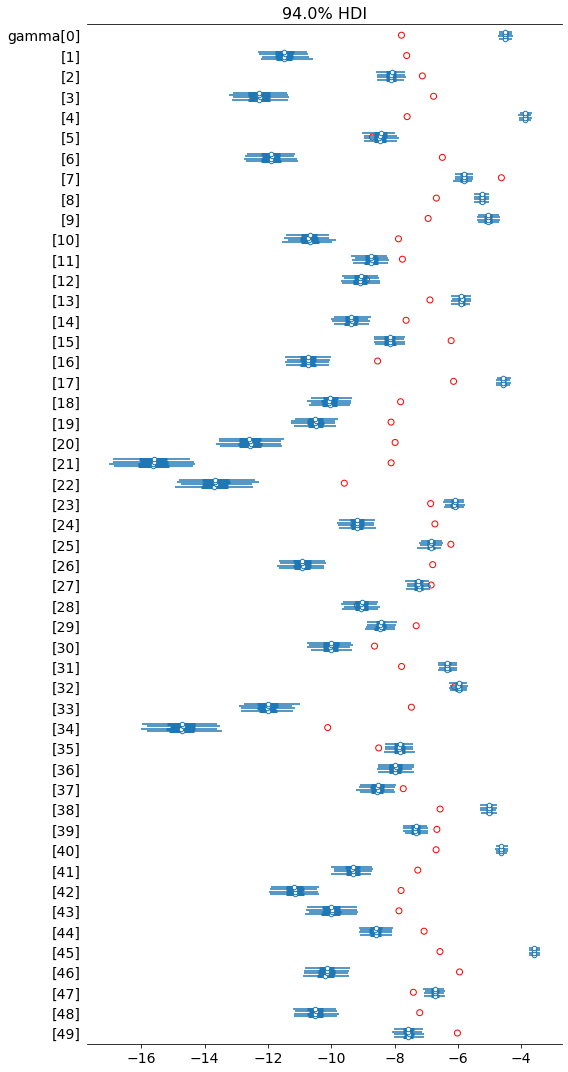

In [121]:
fig ,ax = plt.subplots(1,1,figsize=(8, 15))
pm.plot_forest( trace2, var_names=["gamma"], ax=ax )
ax.scatter( true_effects["decay"][::-1]*1000, ax.get_yticks(), 
            facecolor="none",edgecolor="r")
plt.tight_layout()

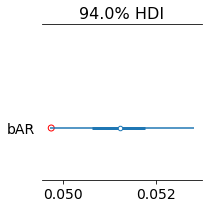

In [119]:
fig ,ax = plt.subplots(1,1,figsize=(3, 3))
pm.plot_forest( trace2, var_names=["bAR"], ax=ax, combined=True )
ax.scatter( true_effects["AR"].mean(), ax.get_yticks(), 
            facecolor="none",edgecolor="r")
plt.tight_layout()

In [123]:
with m2:
    preds = pm.sample_posterior_predictive(trace2)

In [153]:
yhat = preds["rentals"].reshape(4000, -1, 999)


/var/folders/m_/3366cw3j3fx4gcwg7_c6f7xr0000gn/T/ipykernel_50215/3661527184.py:3: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  bounds = az.hdi(arr)


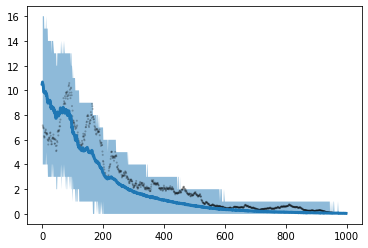

In [180]:
idx = np.random.choice(M)
arr = yhat[:,idx,:]
bounds = az.hdi(arr)
plt.plot(arr.mean(0), lw=3)
plt.fill_between(t[1:], bounds[:,0], bounds[:,1], alpha=0.5)
plt.scatter(t[1:], df.loc[lambda d: d["style"]==f"P{idx}"].y, 
            edgecolor="k",facecolor="none", alpha=0.25, s=1)